In [1]:
# Sample solution is based on nontebooks by Artem Borzov

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import tables as tb
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Load Datasets

In [2]:
train = pd.read_hdf('training/open30.h5') # pick just a single brick
test = pd.read_hdf('test/test.h5')

In [3]:
test = test.reset_index(drop=True)

In [4]:
test.head()

TX        TY             X             Y        Z  data_ind
0  0.087240  0.119438  86536.218750  62988.312500  56892.0         0
1 -0.380208  0.198382  93346.765625  58062.937500  14223.0         0
2 -0.348549 -0.099981  66129.578125  23038.673828  46548.0         0
3  0.585342 -0.126879  68825.523438  55186.625000  45255.0         0
4  0.038579 -0.131510  36366.941406  47564.878906   9051.0         0

In [5]:
train.head()

TX        TY             X             Y        Z  event_id  signal  \
0 -0.248382  0.072824  37014.070312  38318.898438  31032.0    -999.0     0.0   
1  0.768548  0.490205  46626.425781  15151.117188  72408.0  188918.0     1.0   
2 -0.132050 -0.049405  54031.640625  69132.320312  60771.0    -999.0     0.0   
3  0.260584  0.207106  56653.531250  35025.765625  43962.0    -999.0     0.0   
4  0.267597  0.111272  42231.714844  47199.027344  20688.0    -999.0     0.0   

   data_ind  
0        21  
1        21  
2        21  
3        21  
4        21

Посмотрим как выглядят ливни внутри одного data_ind

In [6]:
CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True, n=2500)

def plot3D(X, target, elev=0, azim=0, title=None, sub=111):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    mappab = ax.scatter(x, y, z, c=target, cmap=CMAP)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

# Этот инструмент позволяет менять точку зрения
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(mappable=mappab, label='Target variable')
    plt.show()
    
feat_XY = ['TX', 'TY', 'X', 'Y']

In [7]:
first = train.loc[train.data_ind == 21, :]

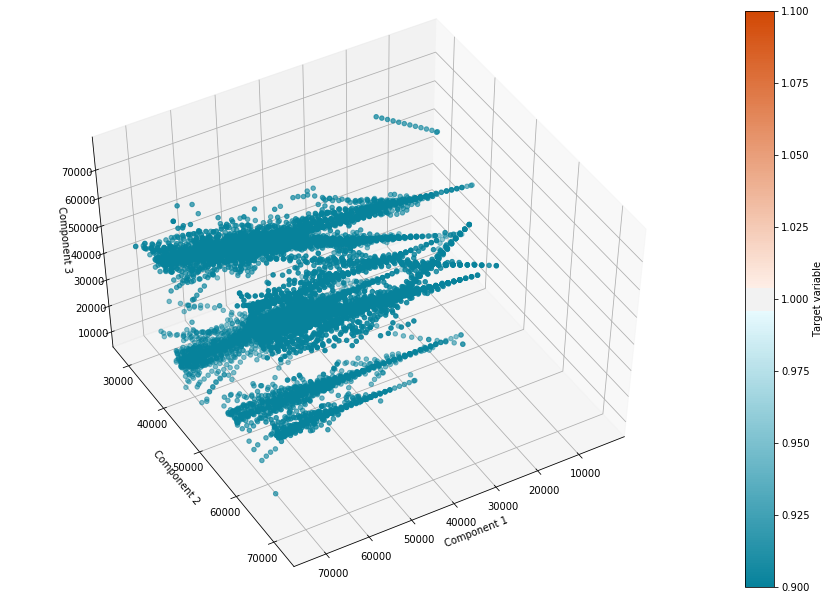

In [8]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=50, azim=60)

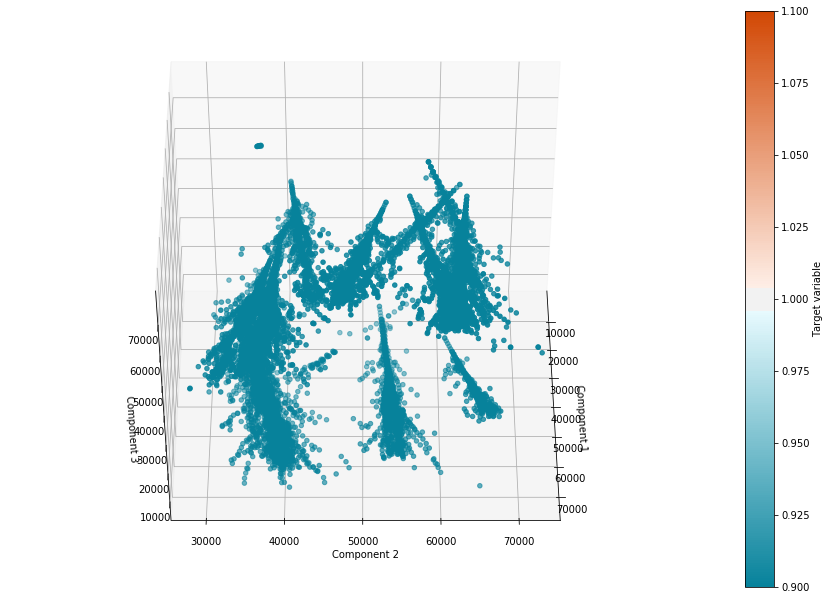

In [9]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=45, azim=0)

## Let's take a look at basetrack distribution along the axis

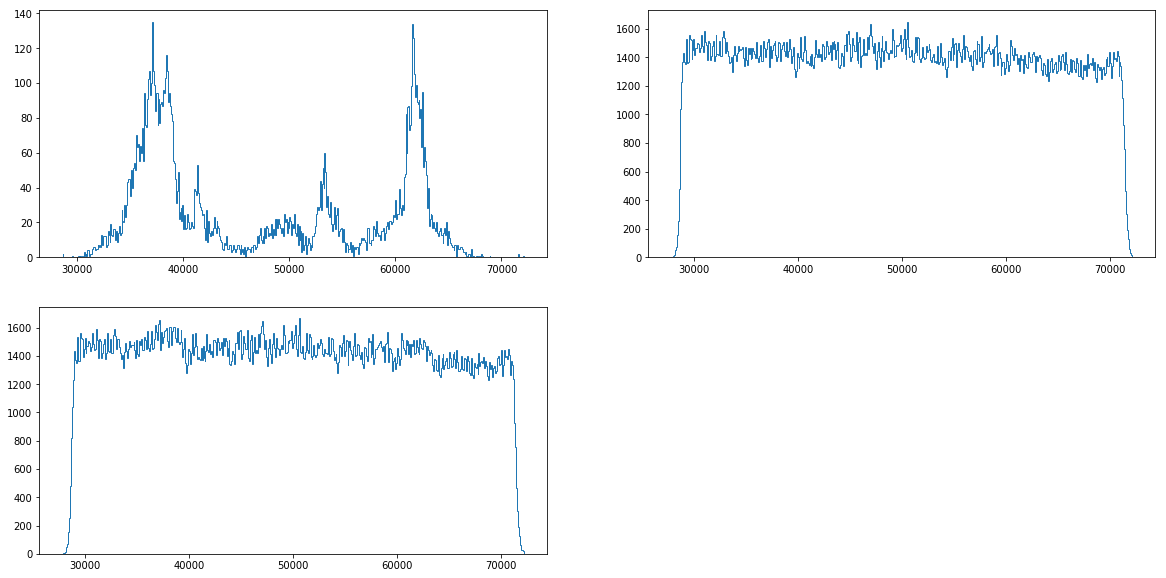

In [10]:
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

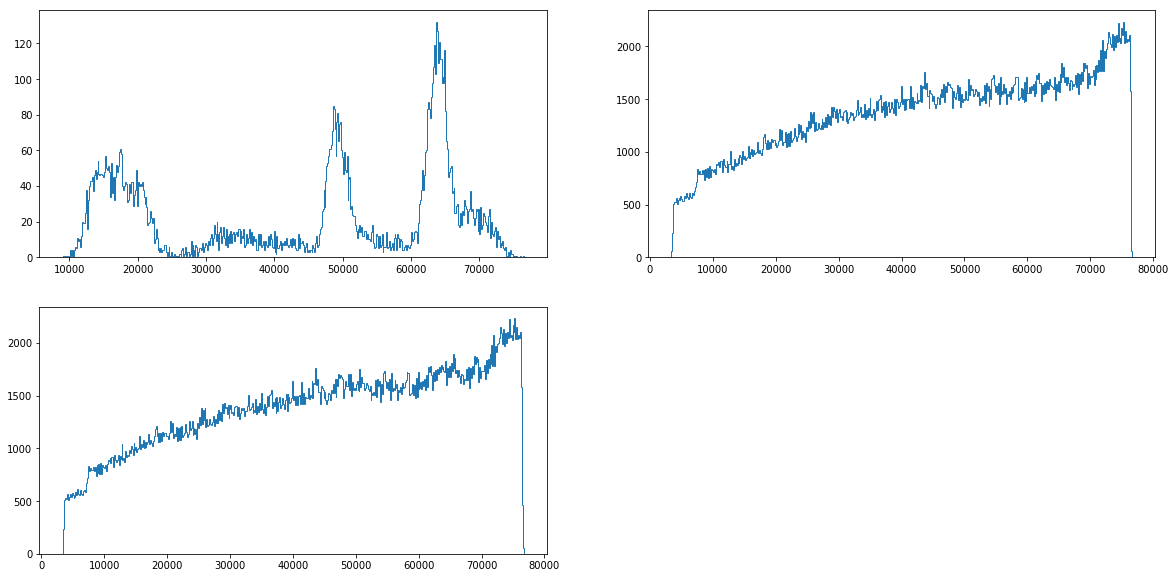

In [11]:
axis = 'Y'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

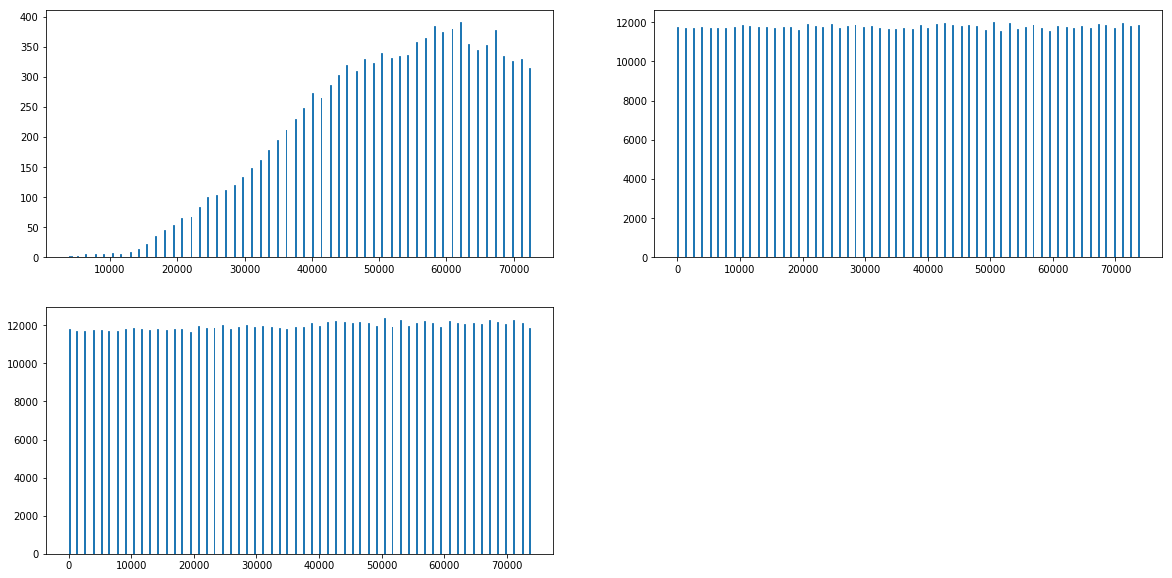

In [12]:
axis = 'Z'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

# Let's group close tracks from neighbour plates into pairs

In [13]:
def add_neighbours(df, k, metric='minkowski'):
    res = []
    
    for data_ind in tqdm(np.unique(df.data_ind)):
        ind = df.loc[df.data_ind == data_ind].copy()
        #как будет замечено, 1293 - это расстояние между слайсами по Z
        ind[['TX', 'TY']] *= 1293
        values = np.unique(ind.Z)
        
        for j in range(1, len(values)):
            z, z_next = (ind.loc[ind.Z == values[j-1]].copy(),
                         ind.loc[ind.Z == values[j]].copy())
            
            b_tree = BallTree(z_next[feat_XY], metric=metric)
            d, i = b_tree.query(z[feat_XY], k=min(k, len(z_next)))
            
            for m in range(i.shape[1]):
                data = z_next.iloc[i[:, m]]
                z_copy = z.copy()
                for col in feat_XY + ['Z']:
                    z_copy[col + '_pair'] = data[col].values
                res.append(z_copy)
            
        res.append(z_next)
        
    res = pd.concat(res)
    for col in feat_XY + ['Z']:
        res['d' + col] = res[col].values - res[col + '_pair'].values
    return res

def balance_train(df, k):
    data = add_neighbours(df, k=k)
    noise = data.event_id == -999
    signal, not_signal = data.loc[np.logical_not(noise)], data.loc[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)

In [14]:
import pickle
train = []
prepared_test =[]
if 0:
    N_bricks=10
    for file in glob.glob('training/open*.h5')[:N_bricks]: #
        train.append(balance_train(pd.read_hdf(file), k=3))
    train = pd.concat(train)

    prepared_test = add_neighbours(test, k=3)
    train.head()
    pickle.dump( train, open( "train.p", "wb" ) )
    pickle.dump( prepared_test, open( "test.p", "wb" ) )
else:
    train=[]
    train = pickle.load( open( "train.p", "rb" ) )
    prepared_test = pickle.load( open( "test.p", "rb" ) )

100%|██████████████████████████████████████████| 10/10 [00:34<00:00,  3.44s/it]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

100%|██████████████████████████████████████████| 11/11 [00:34<00:00,  3.15s/it]


TX     TX_pair          TY     TY_pair             X        X_pair  \
0 -86.840851  -94.468147   92.664032  123.360336  47257.558594  47264.585938   
1 -94.468147  -89.869354  123.360336   99.934273  47264.585938  47168.984375   
2 -94.468147  339.412476  123.360336   69.291908  47264.585938  47322.609375   
3 -94.468147  275.844818  123.360336  159.851212  47264.585938  46879.843750   
4 -89.869354  -70.092018   99.934273   84.584602  47168.984375  47085.210938   

              Y        Y_pair            Z       Z_pair  data_ind  event_id  \
0  11238.640625  11231.140625  5172.000000  5426.527344       261  183825.0   
1  11231.140625  11332.085938  5426.527344  6465.000000       261  183825.0   
2  11231.140625  11128.431641  5426.527344  6465.000000       261  183825.0   
3  11231.140625  11431.775391  5426.527344  6465.000000       261  183825.0   
4  11332.085938  11426.468750  6465.000000  7758.000000       261  183825.0   

   signal         dTX        dTY          dX          dY           dZ  
0     1.0    7.627296 -30.696304   -7.027344    7.500000  -254.527344  
1     1.0   -4.598793  23.426064   95.601562 -100.945312 -1038.472656  
2     1.0 -433.880615  54.068428  -58.023438  102.708984 -1038.472656  
3     1.0 -370.312958 -36.490875  384.742188 -200.634766 -1038.472656  
4     1.0  -19.777336  15.349670   83.773438  -94.382812 -1293.000000

In [20]:
from sklearn.preprocessing import StandardScaler


y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind'], axis=1)
X_test  = prepared_test.drop(['data_ind'], axis=1)

scaler       = StandardScaler().fit(X_train.fillna(0));
X_train_norm = scaler.transform(X_train.fillna(0) );
X_test_norm  = scaler.transform(X_test.fillna(0)  );

def save_probas_to_csv(probas,prepared_test=prepared_test):
    vec = np.squeeze(probas)
    df = pd.DataFrame({'id': prepared_test.index, 'signal': vec}).groupby('id')
    agg = df.aggregate(('mean')).loc[:, ['signal']]
    agg.to_csv('submission.csv.gz', index=True, compression='gzip')
    

## DNN Approach

1. use standard feature set. 
2. Apply fillna(0) on both train and test data. 
3. Normalize data using sklearn.preprocessing.Normalizer(); 
* fit train data to normalizer, 
* then transform both train and test data (so that they are normalized). 
4. build keras 3 layers neural net 
<code>
model.add( 
    Dense(256) 
    ('relu') 
    Dropout(0.5) 
    Dense(256) 
    ('relu') 
    Dropout(0.5) 
    Dense(256) 
    ('relu') 
    Dropout(0.5)
    Dense(1) 
    ('sigmoid') 
     (optimizer='adam', 
    loss='binary_crossentropy'). nb_epoch=20, batch_size=256, shuffle=True.
 </code>
    Loss after 20 epochs should be 0.4137. 
5. generate probas by neural_net.predict_proba(normTestData).
6. Get 90 points. I guess you can get more if you tune this DNN model.

Oleg.

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train);
X_train_norm = scaler.transform(X_train);

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD , adam

from keras.regularizers import l2

def get_dnn_model():
    L2=0
    
    model = Sequential()
    model.add(Dense(256, input_dim=15, init='glorot_normal',kernel_regularizer =l2(L2)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    for i in range(0, 2):
        model.add(Dense(400, init='glorot_normal',kernel_regularizer =l2(L2)))
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
   
    model.add(Dense(1, init='glorot_normal'))
    model.add(Activation('sigmoid'))
    ADAM = adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model

In [28]:
%%time
from keras.callbacks import EarlyStopping , ModelCheckpoint

callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model_dnn.h5', monitor='val_loss', save_best_only=True)]

model_dnn = get_dnn_model();
batch = 2**16;
  

if 1:
    model_dnn.fit(X_train_norm     , y_train, 
                  batch_size        = batch,
                  epochs            = 20,
                  validation_split  = 0.2,
                  shuffle           = True,
                  verbose           = 1   ,
                  callbacks         = callbacks ) 
    model_dnn.save_weights("dnn_model.h5")
else:
    model_dnn.load_weights("dnn_model.h5")
    


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=15, kernel_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_regularizer=<keras.reg..., kernel_initializer="glorot_normal")`
  app.launch_new_instance()
C:\P

Train on 7592027 samples, validate on 1898007 samples
Epoch 1/20
7592027/7592027 [==============================] - ETA: 1:36 - loss: 0.721 - ETA: 53s - loss: 0.712 - ETA: 38s - loss: 0.70 - ETA: 31s - loss: 0.69 - ETA: 27s - loss: 0.69 - ETA: 24s - loss: 0.68 - ETA: 22s - loss: 0.68 - ETA: 20s - loss: 0.67 - ETA: 19s - loss: 0.67 - ETA: 18s - loss: 0.66 - ETA: 17s - loss: 0.66 - ETA: 16s - loss: 0.65 - ETA: 15s - loss: 0.65 - ETA: 15s - loss: 0.64 - ETA: 14s - loss: 0.64 - ETA: 14s - loss: 0.64 - ETA: 13s - loss: 0.63 - ETA: 13s - loss: 0.63 - ETA: 13s - loss: 0.63 - ETA: 12s - loss: 0.63 - ETA: 12s - loss: 0.62 - ETA: 12s - loss: 0.62 - ETA: 12s - loss: 0.62 - ETA: 11s - loss: 0.62 - ETA: 11s - loss: 0.62 - ETA: 11s - loss: 0.61 - ETA: 11s - loss: 0.61 - ETA: 10s - loss: 0.61 - ETA: 10s - loss: 0.61 - ETA: 10s - loss: 0.61 - ETA: 10s - loss: 0.61 - ETA: 10s - loss: 0.60 - ETA: 9s - loss: 0.6082 - ETA: 9s - loss: 0.606 - ETA: 9s - loss: 0.605 - ETA: 9s - loss: 0.604 - ETA: 9s - loss: 

7592027/7592027 [==============================] - ETA: 41s - loss: 0.45 - ETA: 25s - loss: 0.45 - ETA: 20s - loss: 0.45 - ETA: 17s - loss: 0.45 - ETA: 16s - loss: 0.45 - ETA: 15s - loss: 0.45 - ETA: 14s - loss: 0.45 - ETA: 13s - loss: 0.45 - ETA: 13s - loss: 0.45 - ETA: 12s - loss: 0.45 - ETA: 12s - loss: 0.45 - ETA: 12s - loss: 0.45 - ETA: 11s - loss: 0.45 - ETA: 11s - loss: 0.45 - ETA: 11s - loss: 0.45 - ETA: 11s - loss: 0.45 - ETA: 10s - loss: 0.45 - ETA: 10s - loss: 0.45 - ETA: 10s - loss: 0.45 - ETA: 10s - loss: 0.45 - ETA: 10s - loss: 0.45 - ETA: 10s - loss: 0.45 - ETA: 9s - loss: 0.4517 - ETA: 9s - loss: 0.451 - ETA: 9s - loss: 0.451 - ETA: 9s - loss: 0.451 - ETA: 9s - loss: 0.451 - ETA: 9s - loss: 0.451 - ETA: 9s - loss: 0.451 - ETA: 8s - loss: 0.451 - ETA: 8s - loss: 0.451 - ETA: 8s - loss: 0.451 - ETA: 8s - loss: 0.451 - ETA: 8s - loss: 0.451 - ETA: 8s - loss: 0.451 - ETA: 8s - loss: 0.451 - ETA: 8s - loss: 0.451 - ETA: 7s - loss: 0.451 - ETA: 7s - loss: 0.451 - ETA: 7s - lo

7592027/7592027 [==============================] - ETA: 38s - loss: 0.38 - ETA: 24s - loss: 0.38 - ETA: 19s - loss: 0.38 - ETA: 17s - loss: 0.38 - ETA: 15s - loss: 0.38 - ETA: 14s - loss: 0.38 - ETA: 13s - loss: 0.38 - ETA: 13s - loss: 0.38 - ETA: 12s - loss: 0.38 - ETA: 12s - loss: 0.38 - ETA: 12s - loss: 0.38 - ETA: 11s - loss: 0.38 - ETA: 11s - loss: 0.38 - ETA: 11s - loss: 0.38 - ETA: 10s - loss: 0.38 - ETA: 10s - loss: 0.38 - ETA: 10s - loss: 0.38 - ETA: 10s - loss: 0.38 - ETA: 10s - loss: 0.38 - ETA: 10s - loss: 0.38 - ETA: 9s - loss: 0.3853 - ETA: 9s - loss: 0.385 - ETA: 9s - loss: 0.385 - ETA: 9s - loss: 0.385 - ETA: 9s - loss: 0.384 - ETA: 9s - loss: 0.384 - ETA: 9s - loss: 0.384 - ETA: 8s - loss: 0.384 - ETA: 8s - loss: 0.384 - ETA: 8s - loss: 0.384 - ETA: 8s - loss: 0.384 - ETA: 8s - loss: 0.384 - ETA: 8s - loss: 0.384 - ETA: 8s - loss: 0.384 - ETA: 8s - loss: 0.384 - ETA: 8s - loss: 0.384 - ETA: 7s - loss: 0.383 - ETA: 7s - loss: 0.383 - ETA: 7s - loss: 0.383 - ETA: 7s - lo

7592027/7592027 [==============================] - ETA: 41s - loss: 0.37 - ETA: 26s - loss: 0.37 - ETA: 20s - loss: 0.37 - ETA: 18s - loss: 0.37 - ETA: 16s - loss: 0.37 - ETA: 15s - loss: 0.37 - ETA: 14s - loss: 0.37 - ETA: 13s - loss: 0.37 - ETA: 13s - loss: 0.37 - ETA: 12s - loss: 0.37 - ETA: 12s - loss: 0.37 - ETA: 12s - loss: 0.37 - ETA: 11s - loss: 0.37 - ETA: 11s - loss: 0.37 - ETA: 11s - loss: 0.37 - ETA: 11s - loss: 0.37 - ETA: 10s - loss: 0.37 - ETA: 10s - loss: 0.37 - ETA: 10s - loss: 0.37 - ETA: 10s - loss: 0.37 - ETA: 10s - loss: 0.37 - ETA: 10s - loss: 0.37 - ETA: 9s - loss: 0.3723 - ETA: 9s - loss: 0.372 - ETA: 9s - loss: 0.372 - ETA: 9s - loss: 0.372 - ETA: 9s - loss: 0.372 - ETA: 9s - loss: 0.372 - ETA: 9s - loss: 0.372 - ETA: 8s - loss: 0.372 - ETA: 8s - loss: 0.372 - ETA: 8s - loss: 0.372 - ETA: 8s - loss: 0.372 - ETA: 8s - loss: 0.372 - ETA: 8s - loss: 0.372 - ETA: 8s - loss: 0.372 - ETA: 8s - loss: 0.372 - ETA: 7s - loss: 0.372 - ETA: 7s - loss: 0.372 - ETA: 7s - lo

7592027/7592027 [==============================] - ETA: 38s - loss: 0.36 - ETA: 25s - loss: 0.36 - ETA: 20s - loss: 0.36 - ETA: 17s - loss: 0.36 - ETA: 16s - loss: 0.36 - ETA: 14s - loss: 0.36 - ETA: 14s - loss: 0.36 - ETA: 13s - loss: 0.36 - ETA: 13s - loss: 0.36 - ETA: 12s - loss: 0.36 - ETA: 12s - loss: 0.36 - ETA: 12s - loss: 0.36 - ETA: 11s - loss: 0.36 - ETA: 11s - loss: 0.36 - ETA: 11s - loss: 0.36 - ETA: 11s - loss: 0.36 - ETA: 10s - loss: 0.36 - ETA: 10s - loss: 0.36 - ETA: 10s - loss: 0.36 - ETA: 10s - loss: 0.36 - ETA: 10s - loss: 0.36 - ETA: 9s - loss: 0.3675 - ETA: 9s - loss: 0.367 - ETA: 9s - loss: 0.367 - ETA: 9s - loss: 0.367 - ETA: 9s - loss: 0.367 - ETA: 9s - loss: 0.367 - ETA: 9s - loss: 0.367 - ETA: 8s - loss: 0.367 - ETA: 8s - loss: 0.367 - ETA: 8s - loss: 0.367 - ETA: 8s - loss: 0.367 - ETA: 8s - loss: 0.367 - ETA: 8s - loss: 0.367 - ETA: 8s - loss: 0.367 - ETA: 8s - loss: 0.367 - ETA: 8s - loss: 0.366 - ETA: 7s - loss: 0.366 - ETA: 7s - loss: 0.366 - ETA: 7s - lo

In [29]:
probas = model_dnn.predict_proba(X_test_norm,batch_size=batch)
save_probas_to_csv(probas,prepared_test=prepared_test)  

True rate is 0.81192 perc


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


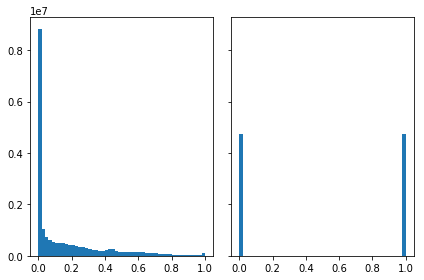

In [30]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True);
n_bins=50;
axs[0].hist(probas     , bins=n_bins);
axs[1].hist(y_train    , bins=n_bins);
probas_ones=probas[probas > 0.9];
rate=len(probas_ones)/len(probas)*100;
print('True rate is %2.5f perc'%rate)




In [43]:
len(probas_ones)

178594

In [37]:
ind[0]

(array([   82594,    82595,    82596, ..., 20166810, 20167355, 20167497],
       dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

## Model Build

In [31]:
y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind'], axis=1)

In [32]:
# import os

# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xg
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [51]:
# param_grid = {
#         'n_estimators':[10, 20], 
#         'max_depth':[15],
# }

# class XGBClassifier_tmp(XGBClassifier):
#     def predict(self, X):
#         return XGBClassifier.predict_proba(self, X)[:, 1]

# clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,
#                                      colsample_bytree=0.8, n_jobs=-1), 
#                    param_grid=param_grid, n_jobs=-1,
#                    scoring='roc_auc',
#                    cv=StratifiedKFold(3, shuffle=True, random_state=0),
#                    verbose=7)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.best_estimator_

In [55]:
xgb_class = XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
         n_estimators=20, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.8, n_jobs=-1, updater='grow_gpu')

In [ ]:
from xgboost import XGBClassifier
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

seed = 42
def add_nonlinear(X_train):
    X_train['X2' ] = X_train['X' ]**2
    X_train['Y2' ] = X_train['Y' ]**2
    X_train['Z2' ] = X_train['Z' ]**2
    X_train['R'  ] = np.sqrt(X_train['Z2']+
                             X_train['Y2']+
                             X_train['Z2'])

    X_train['dX2'] = X_train['dX']**2
    X_train['dY2'] = X_train['dY']**2
    X_train['dZ2'] = X_train['dZ']**2
    X_train['dR' ] = np.sqrt(X_train['dZ2']+
                             X_train['dY2']+
                             X_train['dZ2'])
    return X_train

# X_train_nl = add_nonlinear(X_train);
# X_train_nl.head


X_train_xgb,X_val_xgb,y_train_xgb,y_val_xgb   = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

if 1:
    print('Create, fit and save classifier')
    xgb = XGBClassifier(base_score=0.5,
                        booster='gbtree',
                        colsample_bylevel=1,
                        colsample_bytree=0.8,
                        gamma=0,
                        learning_rate=1/30, 
                        max_delta_step=0,
                        max_depth=15+6,
                        min_child_weight=1,
                        missing=None,
                        n_estimators=30,
                        n_jobs=-1,
                        nthread=None,
                        objective='binary:logistic',
                        random_state=0,
                        reg_alpha=0, 
                        reg_lambda=1, 
                        scale_pos_weight=1, 
                        eval_metric  = 'auc',
                        seed   = None,
                        silent = False, 
                        subsample = 1,
                        updater='grow_gpu_hist')
    xgb.fit(X_train_xgb, y_train_xgb)
    pickle.dump(xgb, open(("xgb_nestim_%d.dat"%xgb.n_estimators), "wb"))
else :
    print('load model')
    xgb = pickle.load( open( "xgb_nestim_50.dat", "rb" ) )

y_pred_val = xgb.predict(X_val_xgb);
r=roc_auc_score(y_val_xgb, y_pred_val)
print('AUC ROC %2.4f'%r)

X_test_nl = add_nonlinear(X_test)   
probas = xgb.predict(X_test.values)  
print('Save to file')
save_probas_to_csv(probas,prepared_test=prepared_test)  

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True);
n_bins=50;
axs[0].hist(y_pred_val , bins=n_bins);
axs[1].hist(probas     , bins=n_bins);



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Save to file


(1898007, 15)

In [54]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc', gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=15,
       min_child_weight=1, missing=nan, n_estimators=200, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=0.8)

In [175]:
from sklearn import metrics as M
train_pred = xgb.predict(X_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


auc nan


In [179]:
print('Predictet, calc metric...')
train_pred=np.squeeze(train_pred)
fpr, tpr, thresholds = M.roc_curve(y_train, train_pred, pos_label=2)
auc = M.auc(fpr, tpr)
print('auc %2.5f'%auc)

Predictet, calc metric...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)